In [9]:
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import  image
import os

读取数据，预处理数据

In [19]:
project_path = os.path.join(os.path.abspath(''),'tf_learning')
project_path

'/home/syh/tf_learning'

W0422 10:12:56.269901 140303092373248 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


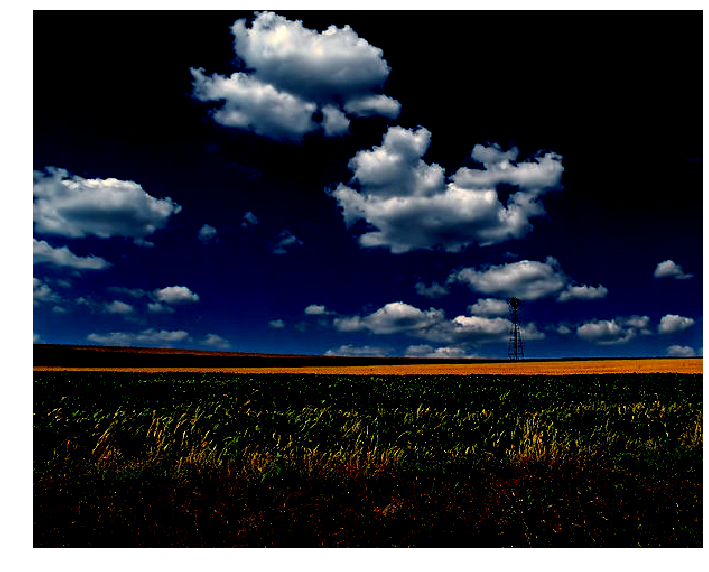

In [21]:
# Download an image and read it into a Numpy array
def  download(url):
    name = url.split('/')[-1]
    # image_path = tf.keras.utils.get_file(name, origin=url)
    image_path = os.path.join(project_path, 'tensorflow2.0/clouds.jpg')
    img = image.load_img(image_path)
    
    return image.img_to_array(img)

# Scale pixel to beteen (-1.0 and 1.0)
def preprocess(img):
    return (img / 127.5) -1

# Undo the preprocessing above
def deprocess(img):
    img = img.copy()
    img /=2.
    img +=0.5
    img *=255.
    
    return np.clip(img, 0, 255).astype('uint8')

# Display an image 
def show(image):
    plt.figure(figsize=(12,12))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
    
url = 'https://storage.googleapis.com/applied-dl/clouds.jpg'
img = preprocess(download(url))
show(deprocess(img))

In [22]:
inception_v3 = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False)

In [23]:
# We'll maximize the activations of these layers
names = ['mixed2', 'mixed3', 'mixed4', 'mixed5']
layers = [inception_v3.get_layer(name).output for name in names]

# Create our feature extraction model
feat_extraction_model = tf.keras.Model(inputs=inception_v3.input, outputs=layers)

In [26]:
for name in names:
    print(inception_v3.get_layer(name).output )

Tensor("mixed2_1/concat:0", shape=(None, None, None, 288), dtype=float32)
Tensor("mixed3_1/concat:0", shape=(None, None, None, 768), dtype=float32)
Tensor("mixed4_1/concat:0", shape=(None, None, None, 768), dtype=float32)
Tensor("mixed5_1/concat:0", shape=(None, None, None, 768), dtype=float32)


In [27]:
def forward(img):
  
  # Create a batch
  img_batch = tf.expand_dims(img, axis=0)
  
  # Forward the image through Inception, extract activations
  # for the layers we selected above
  return feat_extraction_model(img_batch)

In [28]:
def calc_loss(layer_activations):
  
  total_loss = 0
  
  for act in layer_activations:
    
    # In gradient ascent, we'll want to maximize this value
    # so our image increasingly "excites" the layer
    loss = tf.math.reduce_mean(act)

    # Normalize by the number of units in the layer
    loss /= np.prod(act.shape)
    total_loss += loss

  return total_loss